This is a copy of my public kaggle kernel: https://www.kaggle.com/joatom/bqml-incl-intersection-clusters
# Intro

The kernel relies as much as possible on BigQuery (BQ). All features are generated in BQ. And the prediction model is also build in BQ.

## Summary
Features:
- city, hour, weekend, month
- 10 clusters of Intersections per city
- Distance to the nearest cluster
- 8 directions of turn (left, right, centered, uturn, centered-left, ...)
- Directions, Entry- and Exit-Heading are embedded and also they are translated into degrees (centered = 90deg; North = 90deg). Afterwards the degree features are split into two features sin(feature_x_deg) and cos(feature_x_deg).

Model:
- Linear Regression


## Next TODOs
- reasonable Train-Valid-Split strategy

## Credits
Some of the ideas are inspired by the following kernels. Please visit and give them upvotes if you like them.
- This kernel is a forked from [BigQuery Machine Learning Tutorial](https://www.kaggle.com/rtatman/bigquery-machine-learning-tutorial).
- The direction features are like the Flow feature in https://www.kaggle.com/jpmiller/intersection-level-eda

In [1]:
# Replace 'kaggle-competitions-project' with YOUR OWN project id here --  
PROJECT_ID = 'kaggle-bq-geotag' #
#PROJECT_ID='kaggle-competitions-project'

from google.cloud import bigquery
client = bigquery.Client(project=PROJECT_ID, location="US")
dataset = client.create_dataset('bqml_example', exists_ok=True)

from google.cloud.bigquery import magics
from kaggle.gcp import KaggleKernelCredentials
magics.context.credentials = KaggleKernelCredentials()
magics.context.project = PROJECT_ID

import seaborn as sns
import matplotlib.pyplot as plt

# create a reference to our table
table = client.get_table("kaggle-competition-datasets.geotab_intersection_congestion.train")

# look at five rows from our dataset
client.list_rows(table, max_results=5).to_dataframe()

,RowId,IntersectionId,Latitude,Longitude,EntryStreetName,ExitStreetName,EntryHeading,ExitHeading,Hour,Weekend,...,TimeFromFirstStop_p40,TimeFromFirstStop_p50,TimeFromFirstStop_p60,TimeFromFirstStop_p80,DistanceToFirstStop_p20,DistanceToFirstStop_p40,DistanceToFirstStop_p50,DistanceToFirstStop_p60,DistanceToFirstStop_p80,City
0,2079854,33,42.34636,-71.09095,Fenway,Fenway,N,N,8,False,...,31,40,44,59,0.0,25.5,32.3,51.8,68.9,Boston
1,2079857,33,42.34636,-71.09095,Fenway,Fenway,N,N,13,False,...,0,10,17,29,0.0,0.0,9.9,21.8,40.4,Boston
2,2079872,33,42.34636,-71.09095,Fenway,Fenway,N,N,15,False,...,22,33,38,60,0.0,43.2,47.3,51.1,65.7,Boston
3,2079893,33,42.34636,-71.09095,Fenway,Fenway,N,N,12,False,...,0,14,18,31,0.0,0.0,15.6,22.5,44.4,Boston
4,2079896,33,42.34636,-71.09095,Fenway,Fenway,N,N,16,False,...,0,23,34,65,0.0,0.0,26.4,52.9,68.9,Boston


In [2]:
%load_ext google.cloud.bigquery

In [3]:
mod_names= ['TotalTimeStopped_p20','TotalTimeStopped_p50','TotalTimeStopped_p80',
            'DistanceToFirstStop_p20','DistanceToFirstStop_p50','DistanceToFirstStop_p80']

# Cluster Intersections per City

In [4]:
%%bigquery city_df
SELECT t.city
  FROM `kaggle-competition-datasets.geotab_intersection_congestion.test` t
UNION DISTINCT
SELECT t.city
  FROM `kaggle-competition-datasets.geotab_intersection_congestion.train` t


In [5]:
cities = list(city_df['city'])

In [6]:
model_changed = False

if model_changed:
    for c in cities:
        sql="""DROP MODEL `bqml_example.model_cluster_"""+c+"""`"""
        client.query(sql)

        print('Dropped',c)
    
    
for c in cities:
    sql="""CREATE MODEL IF NOT EXISTS `bqml_example.model_cluster_"""+c+"""`
    OPTIONS(model_type='kmeans',
            NUM_CLUSTERS = 10) AS
    SELECT
        latitude,
        longitude
    FROM
      `kaggle-competition-datasets.geotab_intersection_congestion.train` t
    WHERE city = '"""+c+"""'
    UNION ALL
    SELECT
        latitude,
        longitude
    FROM
      `kaggle-competition-datasets.geotab_intersection_congestion.test` t
    WHERE city = '"""+c+"""'"""

    client.query(sql)

    print('Done with',c)

Done with Boston
Done with Philadelphia
Done with Atlanta
Done with Chicago


## Checkout the clusters
Using Boston as an example

In [7]:
%%bigquery eda_df
WITH city_cluster AS (
    SELECT (SELECT MIN(d.DISTANCE) FROM UNNEST(NEAREST_CENTROIDS_DISTANCE) d) AS dist_to_cluster_center, 
           CONCAT(m.city,"_",CAST(m.CENTROID_ID AS STRING)) AS city_cluster,
           m.* EXCEPT (nearest_centroids_distance, CENTROID_ID) 
      FROM ML.PREDICT(MODEL `bqml_example.model_cluster_boston`, 
                   (SELECT t.RowId,
                   t.city,
                           t.IntersectionId,
                           t.Latitude,
                           t.Longitude,
                           #t.EntryStreetName,
                           #t.ExitStreetName,
                           t.EntryHeading,
                           t.ExitHeading,
                           t.Hour,
                           t.Weekend,
                           t.Month,
                           #t.Path,
                           t.TotalTimeStopped_p20,
                           #t.TotalTimeStopped_p40,
                           t.TotalTimeStopped_p50,
                           #t.TotalTimeStopped_p60,
                           t.TotalTimeStopped_p80,
                           #t.TimeFromFirstStop_p20,
                           #t.TimeFromFirstStop_p40,
                           #t.TimeFromFirstStop_p50,
                           #t.TimeFromFirstStop_p60,
                           #t.TimeFromFirstStop_p80,
                           t.DistanceToFirstStop_p20,
                           #t.DistanceToFirstStop_p40,
                           t.DistanceToFirstStop_p50,
                           #t.DistanceToFirstStop_p60,
                           t.DistanceToFirstStop_p80,
                           'TRAIN' AS source
                     FROM `kaggle-competition-datasets.geotab_intersection_congestion.train` t
                    WHERE city = 'Boston' 
                    #  AND rowid in(2209678,2209692)
                    UNION ALL
                    SELECT t.RowId,
                    t.city,
                           t.IntersectionId,
                           t.Latitude,
                           t.Longitude,
                           #t.EntryStreetName,
                           #t.ExitStreetName,
                           t.EntryHeading,
                           t.ExitHeading,
                           t.Hour,
                           t.Weekend,
                           t.Month,
                           #t.Path,
                           null as TotalTimeStopped_p20,
                           #null as TotalTimeStopped_p40,
                           null as TotalTimeStopped_p50,
                           #null as TotalTimeStopped_p60,
                           null as TotalTimeStopped_p80,
                           #null as TimeFromFirstStop_p20,
                           #null as TimeFromFirstStop_p40,
                           #null as TimeFromFirstStop_p50,
                           #null as TimeFromFirstStop_p60,
                           #null as TimeFromFirstStop_p80,
                           null as DistanceToFirstStop_p20,
                           #null as DistanceToFirstStop_p40,
                           null as DistanceToFirstStop_p50,
                           #null as DistanceToFirstStop_p60,
                           null as DistanceToFirstStop_p80,
                           'TEST' AS source
                     FROM `kaggle-competition-datasets.geotab_intersection_congestion.test` t
                    WHERE city = 'Boston' 
                    #  AND rowid in(2209678,2209692)
                    )) m
)
SELECT cc.source,
       cc.city,
       cc.city_cluster, 
       count(1) cnt, 
       avg(cc.dist_to_cluster_center) avg_dist_to_cluster_center, 
       stddev(cc.dist_to_cluster_center) stddev_dist_to_cluster_center, 
       min(cc.dist_to_cluster_center) min_dist_to_cluster_center, 
       max(cc.dist_to_cluster_center) max_dist_to_cluster_center,
       avg(avg(cc.dist_to_cluster_center)*(count(1)-1)) over(partition by cc.city) avg_dist_to_cluster_center_over_city
  FROM city_cluster cc
 GROUP BY cc.source, 
          cc.city, 
          cc.city_cluster;

In [8]:
eda_df.sort_values(by=['source','city_cluster']).head(100)

,source,city,city_cluster,cnt,avg_dist_to_cluster_center,stddev_dist_to_cluster_center,min_dist_to_cluster_center,max_dist_to_cluster_center,avg_dist_to_cluster_center_over_city
8,TEST,Boston,Boston_1,42271,0.466131,0.211686,0.039200,1.314788,13049.52078
2,TEST,Boston,Boston_10,50372,0.450509,0.158993,0.013984,0.847548,13049.52078
5,TEST,Boston,Boston_2,66518,0.350224,0.142395,0.014462,0.722907,13049.52078
1,TEST,Boston,Boston_3,45069,0.489135,0.182818,0.087381,0.829767,13049.52078
6,TEST,Boston,Boston_4,22680,0.464697,0.176813,0.079621,0.888461,13049.52078
0,TEST,Boston,Boston_5,69299,0.456774,0.175848,0.072452,0.893111,13049.52078
3,TEST,Boston,Boston_6,30369,0.462176,0.208277,0.014275,0.974957,13049.52078
7,TEST,Boston,Boston_7,27394,0.327744,0.149575,0.015647,0.758689,13049.52078
9,TEST,Boston,Boston_8,17778,0.374388,0.207027,0.023661,0.920327,13049.52078
4,TEST,Boston,Boston_9,34092,0.668244,0.308577,0.037550,1.563004,13049.52078


(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

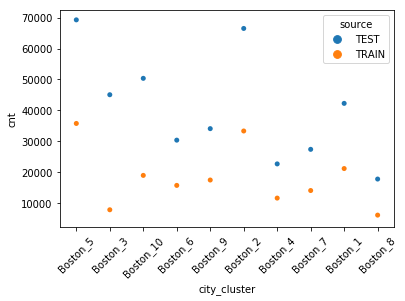

In [9]:
sns.swarmplot(x='city_cluster',y='cnt', data=eda_df ,hue='source')

plt.xticks(rotation=45)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

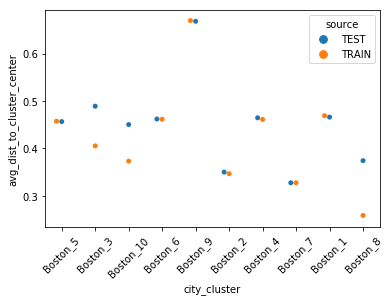

In [10]:
sns.swarmplot(x='city_cluster',y='avg_dist_to_cluster_center', data=eda_df ,hue='source')

plt.xticks(rotation=45)

## Create city_cluster table

In [11]:
def feature_sql(model_name, rowid_split, incl_rowid, tab): 
    
    if incl_rowid:
        rowid = "t.RowId,"
    else:
        rowid = ""
    
    if tab == 'test':
        label = ""
    elif model_name == 'ALL':
        label = """t.TotalTimeStopped_p20,
                t.TotalTimeStopped_p50,
                t.TotalTimeStopped_p80,
                t.DistanceToFirstStop_p20,
                t.DistanceToFirstStop_p50,
                t.DistanceToFirstStop_p80,"""
    else:
        label = """t."""+model_name+""" as label,"""
    
    sql = ""
    
    for c in cities:
        features = """SELECT """+label+"""
                             """+rowid+"""
                             t.city,
                             t.EntryHeading,
                             t.ExitHeading,
                             t.Hour,
                             t.Weekend,
                             t.Month,
                             t.Latitude,
                             t.Longitude,
                             case 
                                 when t.entryheading = t.exitheading THEN
                                  "C"
                                 when ("N" in (t.entryheading, t.exitheading) and "S" in (t.entryheading, t.exitheading)) 
                                      OR 
                                      ("E" in (t.entryheading, t.exitheading) and "W" in (t.entryheading, t.exitheading)) 
                                      OR 
                                      ("NE" in (t.entryheading, t.exitheading) and "SW" in (t.entryheading, t.exitheading))  
                                      OR 
                                      ("SE" in (t.entryheading, t.exitheading) and "NW" in (t.entryheading, t.exitheading)) 
                                 THEN
                                  "U" 
                                 when (t.entryheading="N" and t.exitheading = "W") 
                                      OR(t.entryheading="NW" and t.exitheading = "SW") 
                                      OR(t.entryheading="W" and t.exitheading = "S") 
                                      OR(t.entryheading="SW" and t.exitheading = "SE") 
                                      OR(t.entryheading="S" and t.exitheading = "E") 
                                      OR(t.entryheading="SE" and t.exitheading = "NE") 
                                      OR(t.entryheading="E" and t.exitheading = "N") 
                                      OR(t.entryheading="NE" and t.exitheading = "NW") 
                                 THEN
                                  "L" 
                                 when (t.entryheading="N" and t.exitheading = "E") 
                                      OR(t.entryheading="NW" and t.exitheading = "NE") 
                                      OR(t.entryheading="W" and t.exitheading = "N") 
                                      OR(t.entryheading="SW" and t.exitheading = "NW") 
                                      OR(t.entryheading="S" and t.exitheading = "W") 
                                      OR(t.entryheading="SE" and t.exitheading = "SW") 
                                      OR(t.entryheading="E" and t.exitheading = "S") 
                                      OR(t.entryheading="NE" and t.exitheading = "SE") 
                                 THEN
                                  "R" 
                                 when (t.entryheading="N" and t.exitheading = "NW") 
                                      OR(t.entryheading="NW" and t.exitheading = "W") 
                                      OR(t.entryheading="W" and t.exitheading = "SW") 
                                      OR(t.entryheading="SW" and t.exitheading = "S") 
                                      OR(t.entryheading="S" and t.exitheading = "SE") 
                                      OR(t.entryheading="SE" and t.exitheading = "E") 
                                      OR(t.entryheading="E" and t.exitheading = "NE") 
                                      OR(t.entryheading="NE" and t.exitheading = "N") 
                                 THEN
                                  "CL" 
                                 when (t.entryheading="N" and t.exitheading = "NE") 
                                      OR(t.entryheading="NW" and t.exitheading = "N") 
                                      OR(t.entryheading="W" and t.exitheading = "NW") 
                                      OR(t.entryheading="SW" and t.exitheading = "W") 
                                      OR(t.entryheading="S" and t.exitheading = "SW") 
                                      OR(t.entryheading="SE" and t.exitheading = "S") 
                                      OR(t.entryheading="E" and t.exitheading = "SE") 
                                      OR(t.entryheading="NE" and t.exitheading = "E") 
                                 THEN
                                  "CR" 
                                 when (t.entryheading="N" and t.exitheading = "SW") 
                                      OR(t.entryheading="NW" and t.exitheading = "S") 
                                      OR(t.entryheading="W" and t.exitheading = "SE") 
                                      OR(t.entryheading="SW" and t.exitheading = "E") 
                                      OR(t.entryheading="S" and t.exitheading = "NE") 
                                      OR(t.entryheading="SE" and t.exitheading = "N") 
                                      OR(t.entryheading="E" and t.exitheading = "NW") 
                                      OR(t.entryheading="NE" and t.exitheading = "W") 
                                 THEN
                                  "UL" 
                                 when (t.entryheading="N" and t.exitheading = "SE") 
                                      OR(t.entryheading="NW" and t.exitheading = "E") 
                                      OR(t.entryheading="W" and t.exitheading = "NE") 
                                      OR(t.entryheading="SW" and t.exitheading = "N") 
                                      OR(t.entryheading="S" and t.exitheading = "NW") 
                                      OR(t.entryheading="SE" and t.exitheading = "W") 
                                      OR(t.entryheading="E" and t.exitheading = "SW") 
                                      OR(t.entryheading="NE" and t.exitheading = "S") 
                                 THEN
                                  "UR" 
                               else null end direction
                       FROM `kaggle-competition-datasets.geotab_intersection_congestion."""+tab+"""` t
                      WHERE city = '"""+c+"""' 
                       AND rowid """+rowid_split
                            
        sql += """
               SELECT (SELECT MIN(d.DISTANCE) FROM UNNEST(NEAREST_CENTROIDS_DISTANCE) d) AS dist_to_cluster_center, 
                      CONCAT(m.city,"_",CAST(m.CENTROID_ID AS STRING)) AS city_cluster,
                      m.* EXCEPT (nearest_centroids_distance, CENTROID_ID,Latitude,Longitude) 
                 FROM ML.PREDICT(MODEL `bqml_example.model_cluster_"""+c+"""`, 
                              ("""+features+""")) m
               UNION ALL"""
        
        
    return sql[:-len("UNION ALL")]

In [12]:
model_changed = False

if model_changed:
    sql="DROP TABLE IF EXISTS `bqml_example.city_cluster_train`"
    job_result=client.query(sql).result()
    sql="DROP TABLE IF EXISTS `bqml_example.city_cluster_test`"
    job_result=client.query(sql).result()

    
sql = "CREATE TABLE IF NOT EXISTS `bqml_example.city_cluster_train` as " + feature_sql('ALL','=rowid', True, 'train')
job_result=client.query(sql).result()
sql = "CREATE TABLE IF NOT EXISTS `bqml_example.city_cluster_test` as " + feature_sql('ALL','=rowid', True, 'test')
job_result=client.query(sql).result()
    
    

In [13]:
%%bigquery

SELECT t.TotalTimeStopped_p20 as label, cc.* except (rowid, TotalTimeStopped_p20,TotalTimeStopped_p50,TotalTimeStopped_p80,DistanceToFirstStop_p20, DistanceToFirstStop_p50, DistanceToFirstStop_p80) 
  FROM `bqml_example.city_cluster_train` cc,
       `kaggle-competition-datasets.geotab_intersection_congestion.train` t
 WHERE cc.rowid = t.rowid
 LIMIT 20;

,label,dist_to_cluster_center,city_cluster,city,EntryHeading,ExitHeading,Hour,Weekend,Month,direction
0,0,0.506579,Chicago_6,Chicago,E,E,10,False,6,C
1,0,0.506579,Chicago_6,Chicago,E,E,14,False,9,C
2,0,0.506579,Chicago_6,Chicago,E,E,6,False,12,C
3,16,0.506579,Chicago_6,Chicago,E,E,8,False,12,C
4,0,0.506579,Chicago_6,Chicago,E,E,9,False,11,C
5,0,0.506579,Chicago_6,Chicago,E,E,15,False,7,C
6,0,0.506579,Chicago_6,Chicago,E,E,3,False,10,C
7,18,0.506579,Chicago_6,Chicago,E,E,15,False,12,C
8,32,0.506579,Chicago_6,Chicago,E,E,18,False,12,C
9,0,0.506579,Chicago_6,Chicago,E,E,11,False,12,C


# Model

In [14]:
%%bigquery
CREATE OR REPLACE FUNCTION `bqml_example.direction2degree`(dir string) AS (
 case dir
   when "C" then
    90
   when 'CL' then
    135
   when "L" then
    180
   when 'UL' then
    225
   when "U" then
    270
   when 'UR' then
    315
   when "R" then
    0
   when 'CR' then
    45
    
   when "N" then
    90
   when 'NW' then
    135
   when "W" then
    180
   when 'SW' then
    225
   when "S" then
    270
   when 'SE' then
    315
   when "E" then
    0
   when 'NE' then
    45
 end
);

""


## Train

In [15]:
%%time
model_changed = True

if model_changed:
    for mn in mod_names:
        sql="DROP MODEL IF EXISTS `bqml_example.model_"+mn+"`"
        client.query(sql).result()

        print('Drop',mn)

for mn in mod_names:
    
    sql="""
    CREATE MODEL IF NOT EXISTS `bqml_example.model_"""+mn+"""`
    OPTIONS(MODEL_TYPE='linear_reg', 
            L2_REG=0.1,
            LS_INIT_LEARN_RATE=0.4) AS 
    SELECT  t."""+mn+""" as label,
            cc.city_cluster,
            cc.city,
            cc.hour,
            cc.weekend,
            cc.month,
            cc.direction,
            cc.entryheading,
            cc.exitheading,
            round(sin(bqml_example.direction2degree(cc.direction)*ACOS(-1)/180),6) direction_sin,
            round(cos(bqml_example.direction2degree(cc.direction)*ACOS(-1)/180),6) direction_cos,
            round(sin(bqml_example.direction2degree(cc.entryheading)*ACOS(-1)/180),6) entryheading_sin,
            round(cos(bqml_example.direction2degree(cc.entryheading)*ACOS(-1)/180),6) entryheading_cos,
            round(sin(bqml_example.direction2degree(cc.exitheading)*ACOS(-1)/180),6) exitheading_sin,
            round(cos(bqml_example.direction2degree(cc.exitheading)*ACOS(-1)/180),6) exitheading_cos,
            round(cc.dist_to_cluster_center,8) dist_to_cluster_center
      FROM `bqml_example.city_cluster_train` cc,
           `kaggle-competition-datasets.geotab_intersection_congestion.train` t
     WHERE t.rowid = cc.rowid
       AND cc.rowid < 2600000;
    """

    client.query(sql).result()

    print('Done with',mn)

Drop TotalTimeStopped_p20
Drop TotalTimeStopped_p50
Drop TotalTimeStopped_p80
Drop DistanceToFirstStop_p20
Drop DistanceToFirstStop_p50
Drop DistanceToFirstStop_p80
Done with TotalTimeStopped_p20
Done with TotalTimeStopped_p50
Done with TotalTimeStopped_p80
Done with DistanceToFirstStop_p20
Done with DistanceToFirstStop_p50
Done with DistanceToFirstStop_p80
CPU times: user 356 ms, sys: 160 ms, total: 516 ms
Wall time: 13min 40s


## Get training statistics


In [16]:
%%time
%%bigquery
SELECT
  *
FROM
  ML.TRAINING_INFO(MODEL `bqml_example.model_TotalTimeStopped_p20`)
ORDER BY iteration 

CPU times: user 44 ms, sys: 4 ms, total: 48 ms
Wall time: 2.81 s


,training_run,iteration,loss,eval_loss,learning_rate,duration_ms
0,0,0,53.376111,58.268749,None,17846


In [17]:
%%time
%%bigquery
SELECT
  *
FROM
  ML.FEATURE_INFO(MODEL `bqml_example.model_TotalTimeStopped_p20`)

CPU times: user 48 ms, sys: 0 ns, total: 48 ms
Wall time: 1.59 s


,input,min,max,mean,median,stddev,category_count,null_count
0,city_cluster,NaN,NaN,NaN,NaN,NaN,39.0,0
1,city,NaN,NaN,NaN,NaN,NaN,4.0,0
2,hour,0.000000,23.000000,12.341548,12.000000,5.924782,NaN,0
3,weekend,NaN,NaN,NaN,NaN,NaN,2.0,0
4,month,1.000000,12.000000,9.094857,9.000000,1.996294,NaN,0
5,direction,NaN,NaN,NaN,NaN,NaN,8.0,0
6,entryheading,NaN,NaN,NaN,NaN,NaN,8.0,0
7,exitheading,NaN,NaN,NaN,NaN,NaN,8.0,0
8,direction_sin,-1.000000,1.000000,0.760110,1.000000,0.424616,NaN,0
9,direction_cos,-1.000000,1.000000,-0.000330,0.000000,0.491869,NaN,0


In [18]:
%%bigquery
SELECT
  *
FROM
  ML.WEIGHTS(MODEL  `bqml_example.model_TotalTimeStopped_p20`,
    STRUCT(true AS standardize))

,processed_input,weight,category_weights
0,city_cluster,NaN,"[{'category': 'Boston_2', 'weight': -0.8926060..."
1,city,NaN,"[{'category': 'Philadelphia', 'weight': 0.2615..."
2,hour,0.212911,[]
3,weekend,NaN,"[{'category': 'false', 'weight': 0.68905702461..."
4,month,-0.087331,[]
5,direction,NaN,"[{'category': 'C', 'weight': -0.08696935022589..."
6,entryheading,NaN,"[{'category': 'E', 'weight': 0.066067094842256..."
7,exitheading,NaN,"[{'category': 'E', 'weight': 0.036743184335222..."
8,direction_sin,-0.922568,[]
9,direction_cos,-0.737986,[]


## Evaluate your model


In [19]:
sql="""SELECT
          *
        FROM ML.EVALUATE(MODEL `bqml_example.model_TotalTimeStopped_p20`, (
        SELECT  t.TotalTimeStopped_p20 as label, 
                cc.city_cluster,
                cc.city,
                cc.hour,
                cc.weekend,
                cc.month,
                cc.direction,
                cc.entryheading,
                cc.exitheading,
                round(sin(bqml_example.direction2degree(cc.direction)*ACOS(-1)/180),6) direction_sin,
                round(cos(bqml_example.direction2degree(cc.direction)*ACOS(-1)/180),6) direction_cos,
                round(sin(bqml_example.direction2degree(cc.entryheading)*ACOS(-1)/180),6) entryheading_sin,
                round(cos(bqml_example.direction2degree(cc.entryheading)*ACOS(-1)/180),6) entryheading_cos,
                round(sin(bqml_example.direction2degree(cc.exitheading)*ACOS(-1)/180),6) exitheading_sin,
                round(cos(bqml_example.direction2degree(cc.exitheading)*ACOS(-1)/180),6) exitheading_cos,
                round(cc.dist_to_cluster_center,8) dist_to_cluster_center
          FROM `bqml_example.city_cluster_train` cc,
               `kaggle-competition-datasets.geotab_intersection_congestion.train` t
         WHERE t.rowid = cc.rowid
         AND t.rowid > 2600000))"""

client.query(sql).to_dataframe()

,mean_absolute_error,mean_squared_error,mean_squared_log_error,median_absolute_error,r2_score,explained_variance
0,2.686802,29.483438,1.14179,1.473028,0.004152,0.010661


# Predict outcomes


In [20]:
def pred(mn, debug=False):
    
    if debug:
        lmt='LIMIT 10'
    else:
        lmt=''
    
    sql="""
    SELECT
      RowId,
      predicted_label as """+mn+"""
    FROM
      ML.PREDICT(MODEL `bqml_example.model_"""+mn+"""`,
        (
        SELECT  cc.RowId, 
                cc.city_cluster,
                cc.city,
                cc.hour,
                cc.weekend,
                cc.month,
                cc.direction,
                cc.entryheading,
                cc.exitheading,
                round(sin(bqml_example.direction2degree(cc.direction)*ACOS(-1)/180),6) direction_sin,
                round(cos(bqml_example.direction2degree(cc.direction)*ACOS(-1)/180),6) direction_cos,
                round(sin(bqml_example.direction2degree(cc.entryheading)*ACOS(-1)/180),6) entryheading_sin,
                round(cos(bqml_example.direction2degree(cc.entryheading)*ACOS(-1)/180),6) entryheading_cos,
                round(sin(bqml_example.direction2degree(cc.exitheading)*ACOS(-1)/180),6) exitheading_sin,
                round(cos(bqml_example.direction2degree(cc.exitheading)*ACOS(-1)/180),6) exitheading_cos,
                round(cc.dist_to_cluster_center,8) dist_to_cluster_center
          FROM `bqml_example.city_cluster_test` cc,
               `kaggle-competition-datasets.geotab_intersection_congestion.test` t
         WHERE t.rowid = cc.rowid
          """+lmt+"""))
        ORDER BY RowId ASC"""

    return client.query(sql).to_dataframe()
    
df=None
for i, mn in enumerate(mod_names):
    if i == 0:
        print('Start', i)
        df = pred(mn)
        df['RowId'] = df['RowId'].apply(str) + '_'+str(i)
        df.rename(columns={'RowId': 'TargetId', mn: 'Target'}, inplace=True)
    else:
        print('Start', i)
        df_temp = pred(mn)
        df_temp['RowId'] = df_temp['RowId'].apply(str) + '_'+str(i)
        df_temp.rename(columns={'RowId': 'TargetId', mn: 'Target'}, inplace=True)
        df=df.append(df_temp)

    print('Done with',mn)

Start 0
Done with TotalTimeStopped_p20
Start 1
Done with TotalTimeStopped_p50
Start 2
Done with TotalTimeStopped_p80
Start 3
Done with DistanceToFirstStop_p20
Start 4
Done with DistanceToFirstStop_p50
Start 5
Done with DistanceToFirstStop_p80


In [21]:
print(df.shape)
df.head(100)

(11522010, 2)


,TargetId,Target
0,0_0,4.171987
1,1_0,0.323337
2,2_0,0.200592
3,3_0,0.359272
4,4_0,0.236528
...,...,...
95,95_0,4.747800
96,96_0,0.408395
97,97_0,0.567075
98,98_0,1.159531


## Output as CSV


In [22]:
df.to_csv('submission.csv', index=False)